# Washington DC Biking data | Hourly Bike Count Prediction | Using Dask 

# 1. EDA + Baseline
MBD Mrad Azoury

In [193]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? no
Nothing done.


In [243]:
# To automatically reload the function file 
%load_ext autoreload
%aimport My_functions
%run My_functions.py
%autoreload 1
%matplotlib inline
warnings.simplefilter(action='ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [297]:
client = Client()

In [222]:
# Data Import
hourly_raw_data = dd.read_csv("hour.csv", blocksize=16e4)

In [223]:
hourly_raw_data.npartitions

8

### Converting `dteday` to date

In [224]:
### Changing the date type
hourly_raw_data["dteday"].map_partitions(
    pd.to_datetime, format="%Y/%m/%d", meta=("datetime64[ns]")
)

Dask Series Structure:
npartitions=8
    datetime64[ns]
               ...
         ...      
               ...
               ...
dtype: datetime64[ns]
Dask Name: to_datetime, 40 tasks

In [10]:
# Making a copy of hourly data for graphs
graph_data_hourly = hourly_raw_data.copy()

In [11]:
graph_data_hourly = graph_data_hourly.compute()
mpl_fig = plt.figure()
ax = plt.axes()
ax.plot(graph_data_hourly["dteday"], graph_data_hourly["cnt"])
ax.plot(graph_data_hourly["dteday"], graph_data_hourly["registered"])
ax.plot(graph_data_hourly["dteday"], graph_data_hourly["casual"])
# ax.legend(['cnt', 'registered', 'casual'], loc='upper left')
# ax.figure(figsize=(20,10))
# locator=MaxNLocator(prune='both',nbins=8)
# ax.xaxis.set_major_locator(locator)


plotly_fig = tls.mpl_to_plotly(mpl_fig)
plotly_fig["layout"]["xaxis"] = {"tickmode": "auto", "nticks": 10}
plotly_fig["layout"]["showlegend"] = True
plotly_fig["layout"] = {"width": 800}
plotly_fig["layout"]["title"] = "Hourly Bike Users"
py.iplot(plotly_fig, filename="Hourly_Bike_Users")

The draw time for this plot will be slow for clients without much RAM.


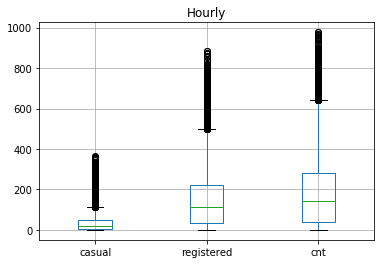

In [12]:
graph_data_hourly.boxplot(column=["casual", "registered", "cnt"])
plt.title("Hourly")
plt.show()

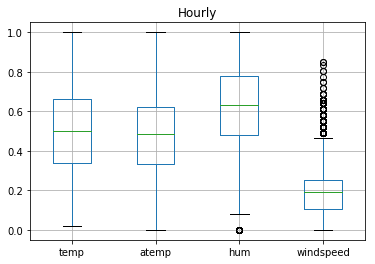

In [13]:
graph_data_hourly.boxplot(column=["temp", "atemp", "hum", "windspeed"])
plt.title("Hourly")
plt.show()

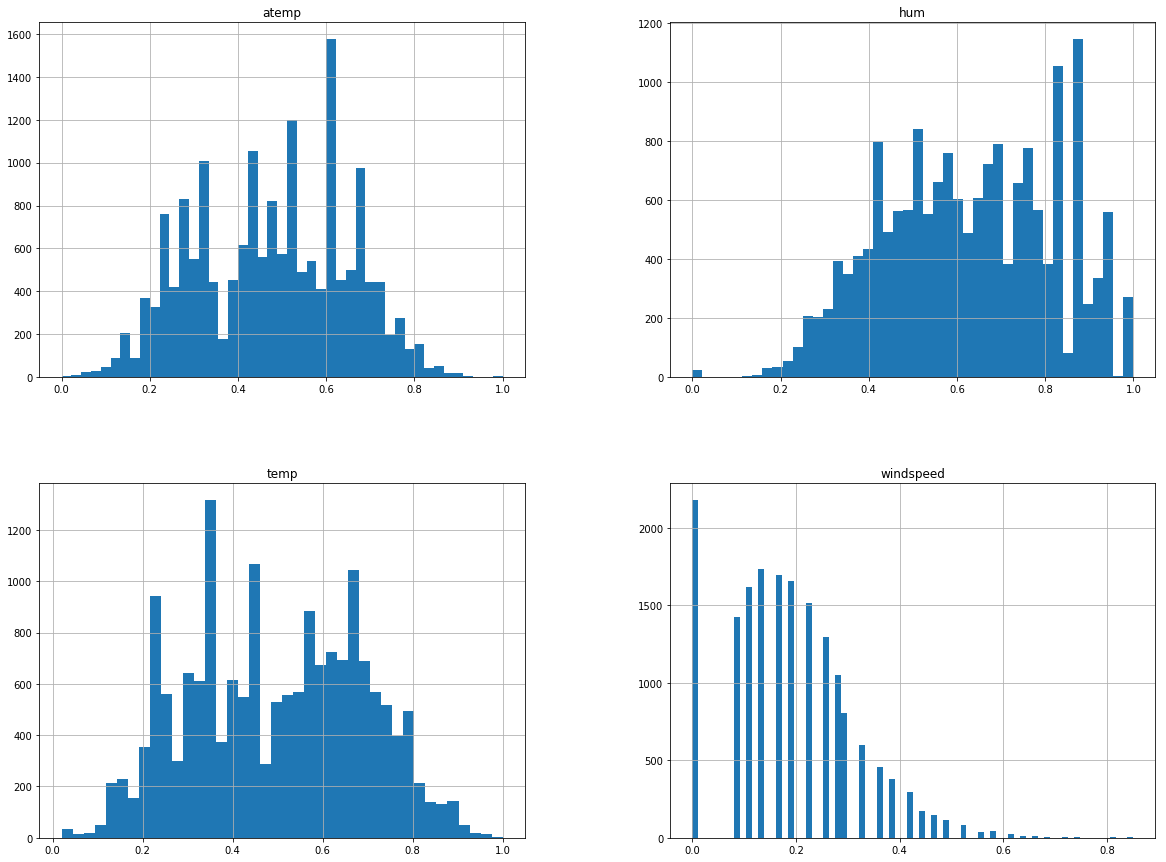

In [14]:
num_bins = "auto"
to_hist = ["atemp", "temp", "hum", "windspeed"]
graph_data_hourly[to_hist].hist(bins=num_bins, figsize=(20, 15))

plt.show()

Text(0.5, 1.0, 'Humidity per Hour')

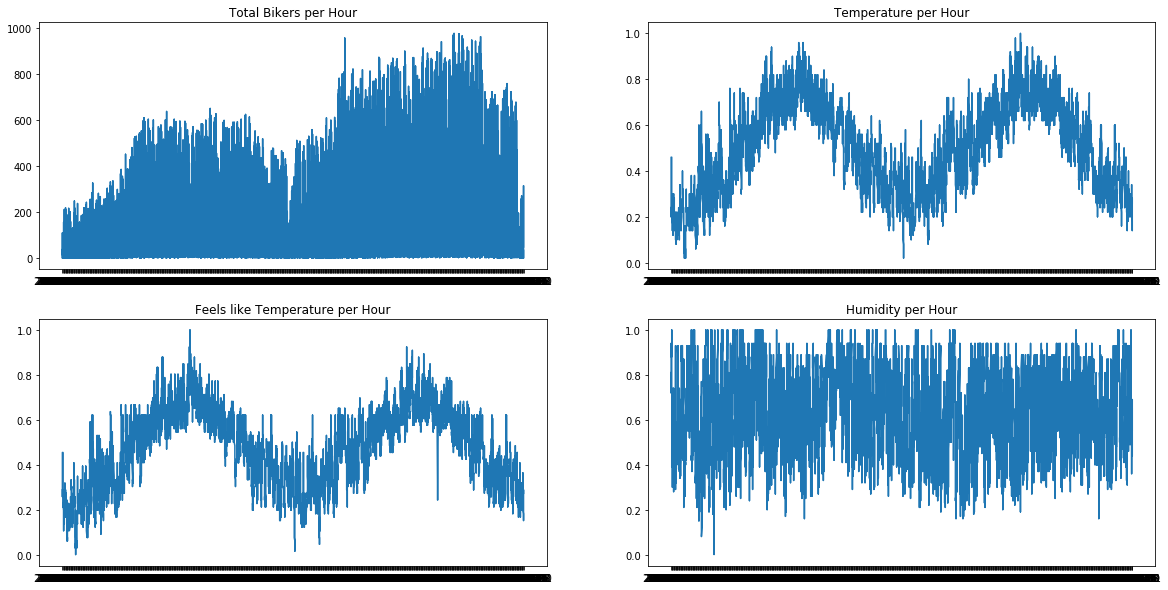

In [15]:
plt.figure(figsize=(20,10))
plt.subplot(2,2, 1)
plt.plot(graph_data_hourly['dteday'],graph_data_hourly['cnt'])
plt.title('Total Bikers per Hour')
plt.subplot(2, 2, 2)
plt.plot(graph_data_hourly['dteday'],graph_data_hourly['temp'])
plt.title('Temperature per Hour')
plt.subplot(2, 2, 3)
plt.plot(graph_data_hourly['dteday'],graph_data_hourly['atemp'])
plt.title('Feels like Temperature per Hour')
plt.subplot(2, 2, 4)
plt.plot(graph_data_hourly['dteday'],graph_data_hourly['hum'])
plt.title('Humidity per Hour')

[Text(0.5, 1.0, 'Weekday wise hourly distribution of Total Bikers')]

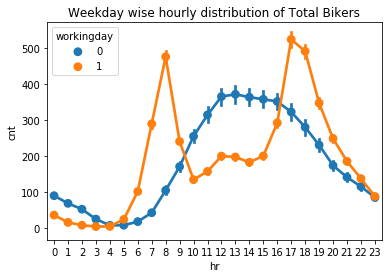

In [16]:
# Option 1 for weekend/weekday graph
fig, ax = plt.subplots()
sns.pointplot(
    data=graph_data_hourly[["hr", "cnt", "workingday"]],
    x="hr",
    y="cnt",
    hue="workingday",
    ax=ax,
)
ax.set(title="Weekday wise hourly distribution of Total Bikers")

Text(0.5, 1.0, 'Humidity per Hour')

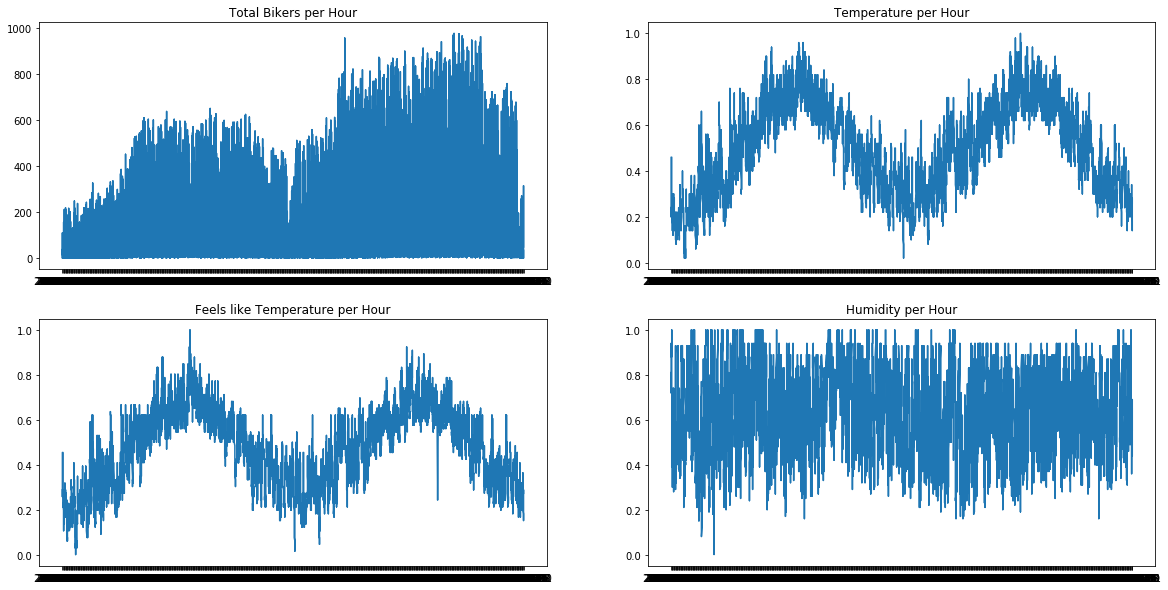

In [17]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(graph_data_hourly["dteday"], graph_data_hourly["cnt"])
plt.title("Total Bikers per Hour")
plt.subplot(2, 2, 2)
plt.plot(graph_data_hourly["dteday"], graph_data_hourly["temp"])
plt.title("Temperature per Hour")
plt.subplot(2, 2, 3)
plt.plot(graph_data_hourly["dteday"], graph_data_hourly["atemp"])
plt.title("Feels like Temperature per Hour")
plt.subplot(2, 2, 4)
plt.plot(graph_data_hourly["dteday"], graph_data_hourly["hum"])
plt.title("Humidity per Hour")

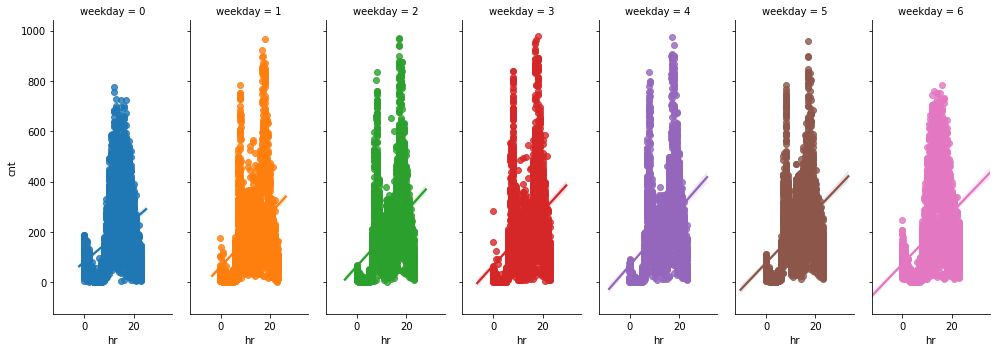

In [18]:
# option 2 for weekend/weekday graphs
g = sns.lmplot(
    x="hr",
    y="cnt",
    hue="weekday",
    col="weekday",
    data=graph_data_hourly,
    aspect=0.4,
    x_jitter=0.1,
)

### EDA after splitting (Working Data / Holiday Days)

In [19]:
workingdays_d = num_name(hourly_raw_data.loc[(hourly_raw_data["workingday"].isin([1]))])
holidays_d = num_name(hourly_raw_data.loc[(~hourly_raw_data["workingday"].isin([1]))])

In [20]:
workingdays = workingdays_d.compute()
holidays = holidays_d.compute()

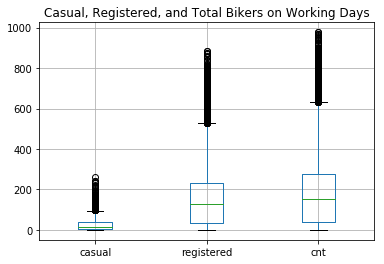

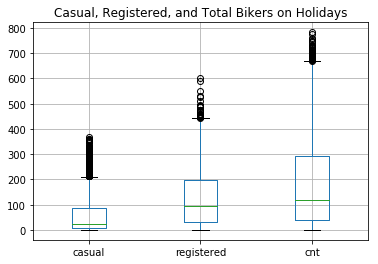

In [21]:
workingdays.boxplot(column=["casual", "registered", "cnt"])
plt.title("Casual, Registered, and Total Bikers on Working Days")
plt.show()
holidays.boxplot(column=["casual", "registered", "cnt"])
plt.title("Casual, Registered, and Total Bikers on Holidays")
plt.show()

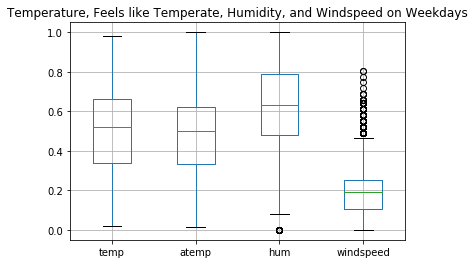

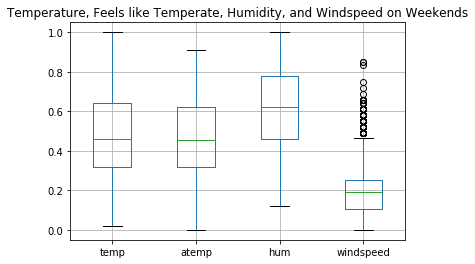

In [22]:
workingdays.boxplot(column=["temp", "atemp", "hum", "windspeed"])
plt.title("Temperature, Feels like Temperate, Humidity, and Windspeed on Weekdays")
plt.show()
holidays.boxplot(column=["temp", "atemp", "hum", "windspeed"])
plt.title("Temperature, Feels like Temperate, Humidity, and Windspeed on Weekends")
plt.show()

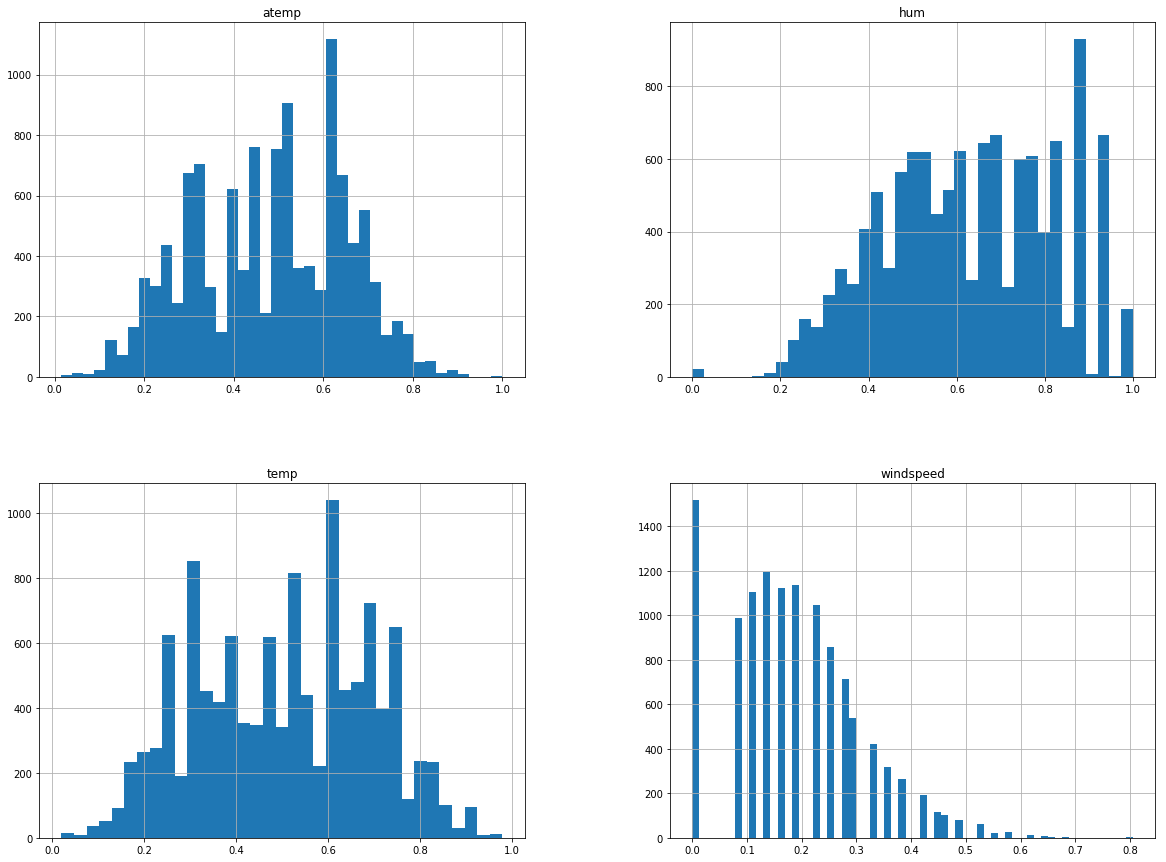

In [23]:
num_bins = "auto"
to_hist = ["atemp", "temp", "hum", "windspeed"]
workingdays[to_hist].hist(bins=num_bins, figsize=(20, 15))

plt.show()

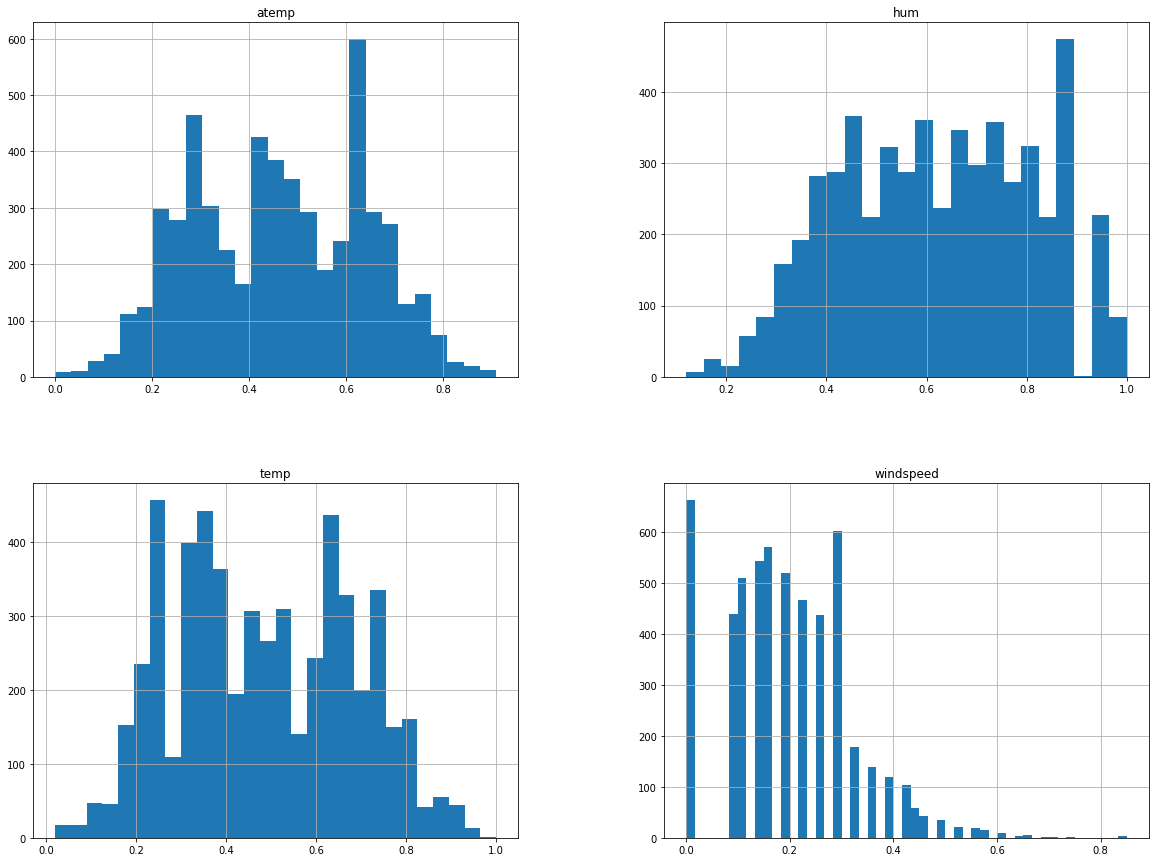

In [24]:
num_bins = "auto"
to_hist = ["atemp", "temp", "hum", "windspeed"]
holidays[to_hist].hist(bins=num_bins, figsize=(20, 15))

plt.show()

Text(0.5, 1.0, 'Humidity on Weekend')

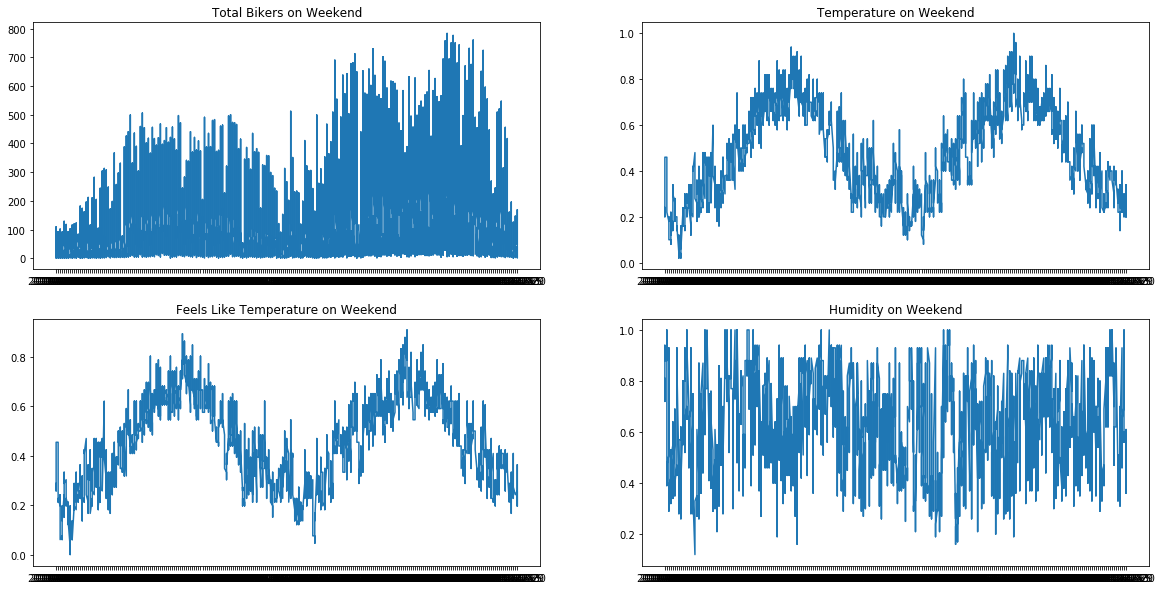

In [25]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(holidays["dteday"], holidays["cnt"])
plt.title("Total Bikers on Weekend")
plt.subplot(2, 2, 2)
plt.plot(holidays["dteday"], holidays["temp"])
plt.title("Temperature on Weekend")
plt.subplot(2, 2, 3)
plt.plot(holidays["dteday"], holidays["atemp"])
plt.title("Feels Like Temperature on Weekend")
plt.subplot(2, 2, 4)
plt.plot(holidays["dteday"], holidays["hum"])
plt.title("Humidity on Weekend")

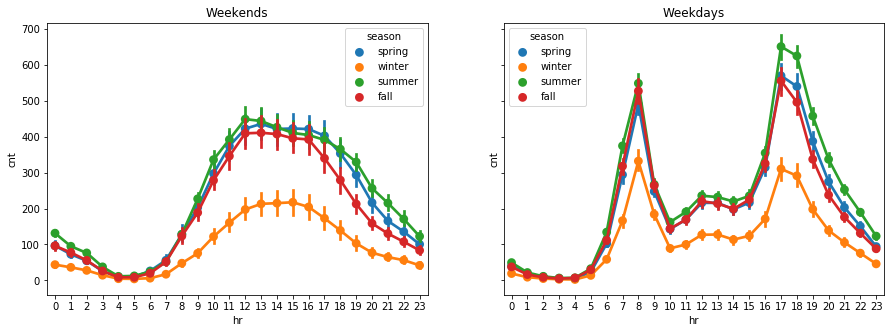

In [26]:
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(15, 5))
sns.pointplot(
    data=holidays[["hr", "cnt", "season"]], x="hr", y="cnt", hue="season", ax=ax[0]
)
sns.pointplot(
    data=workingdays[["hr", "cnt", "season"]], x="hr", y="cnt", hue="season", ax=ax[1]
)
ax[0].set(title="Weekends")
ax[1].set(title="Weekdays")
plt.show()
fig.savefig("test2")

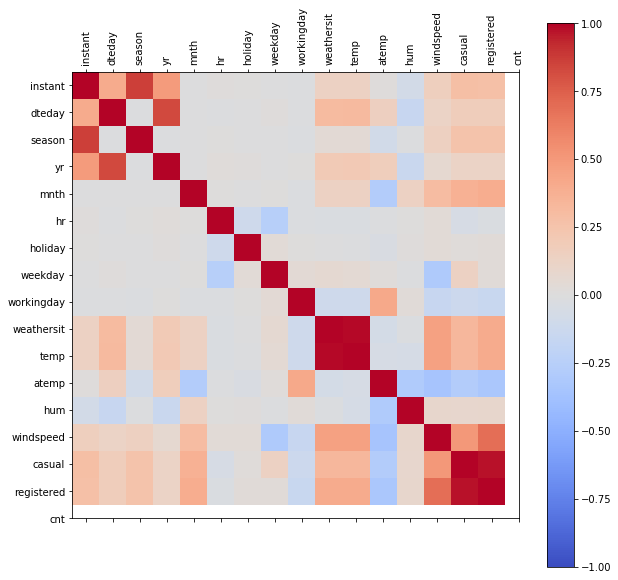

In [27]:
#Hourly
plt.rcParams["figure.figsize"] = (10,10)
corr = hourly_raw_data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(hourly_raw_data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(hourly_raw_data.columns)
ax.set_yticklabels(hourly_raw_data.columns)
plt.show()

# Modeling (Baseline)

### One hot Encoding
For `season`, `weathersit`, `mnth`,`weekday`,`hr`

In [225]:
category  = ['season', 'weathersit', 'mnth','weekday','hr']

hourly_raw_data = onehot_encode(hourly_raw_data,category)

In [226]:
hourly_raw_data.compute().index.duplicated().sum()

14900

In [227]:
hourly_raw_data= hourly_raw_data.reset_index()

In [228]:
t = hourly_raw_data.drop(
    ["cnt", "casual", "registered", "dteday"], axis=1
)  
T = hourly_raw_data['cnt']

### Splitting train test

In [240]:
X_Train = hourly_raw_data[
    hourly_raw_data["instant"]
    < 15212
].drop(
    ["cnt", "casual", "registered", "dteday"], axis=1
)  
X_Test = hourly_raw_data[
    (
        hourly_raw_data["instant"]
    >= 15212
    )
].drop(
    ["cnt", "casual", "registered", "dteday"], axis=1
)  ## NONE OF THEM IN DATA
Y_cnt_test = hourly_raw_data[
    (
        hourly_raw_data["instant"]
    >= 15212
    )
]['cnt']
Y_cnt_train = hourly_raw_data[
    hourly_raw_data["instant"]
    < 15212
]["cnt"]

In [298]:
with joblib.parallel_backend('dask'):
    lr = LinearRegression()
    lr.fit(X_Train, Y_cnt_train)

0.6362811513907103

In [299]:
print("Mean squared error (MSE): {:.2f}".format(mean_squared_error(Y_cnt_test,y_pred)))
print("Variance score (R2): {:.2f}".format(r2_score(Y_cnt_test,y_pred)))

Mean squared error (MSE): 14780.41
Variance score (R2): 0.64
